In [7]:
import sys
sys.path.append('../_amigocloud')

In [8]:
from amigocloud import AmigoCloud
import pandas as pd
from shapely import wkb

import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
#from shapely.geometry import Point, MultiPoint

In [9]:
# ruta de carpera donde estan las llaves
ruta = open('../ruta.txt')
ruta = ruta.readlines()[0]

In [10]:
# leer token
acceso = open(ruta + '/_keys/api_amigocloud.key','r')
api_token = acceso.readlines()[0]
acceso.close()
amigocloud = AmigoCloud(token=api_token)
amigocloud

# ACTUALIZAR SHP PLANIFICACION

In [84]:
semana = 1

In [85]:
# leer los dos shps de siembra y puntos de planificacion
path_siembras = r'G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\SHP\SIEMBRAS.shp'
path_cat = r'G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\SHP\catastro140624.shp'
path_puntos = r'G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\SHP\PUNTOS_PLAN.shp'

gdf_siembras = gpd.read_file(path_siembras)
gdf_puntos = gpd.read_file(path_puntos)
gdf_cat = gpd.read_file(path_cat)

In [86]:
# verifica si ambos shps tienen el mismo CRS
if gdf_siembras.crs == gdf_puntos.crs:
    print('Ambas capas tienen el mismo CRS')
else:
    print('No tienen el mismo CRS')

Ambas capas tienen el mismo CRS


<Axes: >

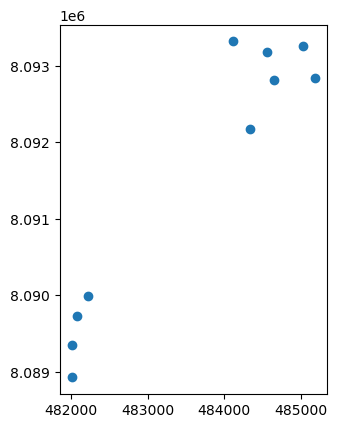

In [87]:
# filtrar la semna de interes
gdf_puntos_sem = gdf_puntos[gdf_puntos['os'] == semana]
gdf_puntos_sem.plot()

In [88]:
gdf_puntos_sem

,unidad_03,unidad_04,os,geometry
0,388,AGROPECUARIA MARIANA S.R.L.,1,"MULTIPOINT (484106.204 8093315.544, 484336.392..."
1,454,AYALA ESPINOSA LEOPOLDO,1,"MULTIPOINT (482005.011 8089351.394, 482011.626..."


In [91]:
path_puntos = r'G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\SHP\PUNTOS_PLAN.shp'
multipoint_gdf = gpd.read_file(path_puntos)

In [92]:
# Crear una lista para almacenar los nuevos registros de puntos individuales
point_records = []
# Iterar sobre cada registro en el GeoDataFrame original
for idx, row in multipoint_gdf.iterrows():
    multipoint_geom = row.geometry
    # Verificar si la geometría es de tipo multipunto
    if isinstance(multipoint_geom, MultiPoint):
        for point in multipoint_geom.geoms:
            # Crear un nuevo registro para cada punto individual
            new_record = row.copy()
            new_record.geometry = point
            point_records.append(new_record)
    else:
        # Si la geometría ya es un punto, simplemente añadir el registro original
        point_records.append(row)

# Crear un nuevo GeoDataFrame con los registros de puntos individuales
puntos_indi = gpd.GeoDataFrame(point_records, crs=multipoint_gdf.crs)

In [93]:
# puntos individuales
puntos_indi

,unidad_03,unidad_04,os,geometry
0,388,AGROPECUARIA MARIANA S.R.L.,1,POINT (484106.204 8093315.544)
0,388,AGROPECUARIA MARIANA S.R.L.,1,POINT (484336.392 8092168.573)
0,388,AGROPECUARIA MARIANA S.R.L.,1,POINT (484554.674 8093180.606)
0,388,AGROPECUARIA MARIANA S.R.L.,1,POINT (484645.955 8092815.480)
0,388,AGROPECUARIA MARIANA S.R.L.,1,POINT (485022.987 8093259.981)
0,388,AGROPECUARIA MARIANA S.R.L.,1,POINT (485185.706 8092839.293)
1,454,AYALA ESPINOSA LEOPOLDO,1,POINT (482005.011 8089351.394)
1,454,AYALA ESPINOSA LEOPOLDO,1,POINT (482011.626 8088924.753)
1,454,AYALA ESPINOSA LEOPOLDO,1,POINT (482077.772 8089725.119)
1,454,AYALA ESPINOSA LEOPOLDO,1,POINT (482216.678 8089993.010)


<Axes: >

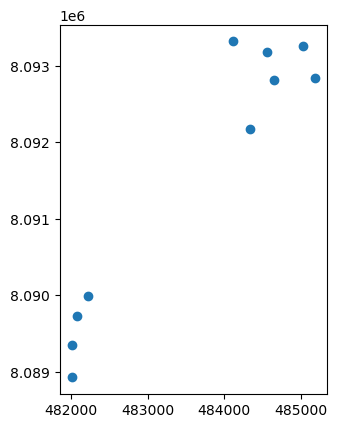

In [94]:
puntos_indi.plot()

In [95]:
# Asegurarse de que ambos GeoDataFrames tienen el mismo sistema de coordenadas (CRS)
if puntos_indi.crs != gdf_siembras.crs:
    print('Los CRS no son iguales')
    #gdf_siembras = gdf_siembras.to_crs(puntos_indi.crs)
else:
    print('Los CRS si son iguales')

Los CRS si son iguales


In [96]:
# Crear un GeoDataFrame vacío para almacenar los puntos que no intersectan con ningún polígono
puntos_indi_solicitado = puntos_indi[~puntos_indi.geometry.apply(lambda point: any(gdf_siembras.contains(point)))]

In [102]:
puntos_indi_solicitado

,unidad_03,unidad_04,os,geometry
0,388,AGROPECUARIA MARIANA S.R.L.,1,POINT (484106.204 8093315.544)
0,388,AGROPECUARIA MARIANA S.R.L.,1,POINT (484645.955 8092815.480)
0,388,AGROPECUARIA MARIANA S.R.L.,1,POINT (485022.987 8093259.981)
1,454,AYALA ESPINOSA LEOPOLDO,1,POINT (482011.626 8088924.753)
1,454,AYALA ESPINOSA LEOPOLDO,1,POINT (482216.678 8089993.010)


In [98]:
# identifoca los lotes que se intersectan
gdf_lotes_cat = gpd.sjoin(gdf_cat, puntos_indi_solicitado, how='inner', predicate='intersects')

In [99]:
# filtra los lotes intersectados en la capa original
poligonos_intersect_cat = gdf_cat.loc[gdf_cat.index.isin(gdf_lotes_cat.index)]

In [100]:
# copy
poligonos_intersect_cat = poligonos_intersect_cat.copy()

In [103]:
poligonos_intersect_cat = poligonos_intersect_cat[['unidad_01', 'unidad_02', 'unidad_03', 'unidad_04', 'unidad_05', 'area', 'geometry']]

In [104]:
poligonos_intersect_cat

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,geometry
3352,19,SANTA BARBARA,388,AGROPECUARIA MARIANA S.R.L.,L9.1,13.37,"POLYGON ((484731.467 8093214.090, 484792.432 8..."
6570,19,SANTA BARBARA,18358,ROJAS AMELUNGE CARLOS,L30.3,30.62,"POLYGON ((482167.376 8088748.923, 481855.906 8..."
7017,19,SANTA BARBARA,18358,ROJAS AMELUNGE CARLOS,L10.2,10.32,"POLYGON ((484672.478 8092564.285, 484524.403 8..."
7946,19,SANTA BARBARA,388,AGROPECUARIA MARIANA S.R.L.,L2,14.00,"POLYGON ((483967.015 8093117.035, 483852.026 8..."
9322,19,SANTA BARBARA,388,AGROPECUARIA MARIANA S.R.L.,L28.1,12.73,"POLYGON ((482501.881 8089944.349, 482501.881 8..."


In [106]:
# CAMBIAR NOMBRE DATOS DE UNIDAD_03 Y UNDIAD_04 DE LOTES SOLICITADOS A LO INDICADO EN LOS PUNTOS
# Iterar sobre cada punto y encontrar el polígono que intersecta
for idx, point in puntos_indi_solicitado.iterrows():
    point_geom = point.geometry
    matching_polygons = poligonos_intersect_cat[poligonos_intersect_cat.intersects(point_geom)]
    
    # Actualizar los campos de los polígonos que intersectan con los valores del punto
    for poly_idx in matching_polygons.index:
        poligonos_intersect_cat.at[poly_idx, 'unidad_03'] = point['unidad_03']
        poligonos_intersect_cat.at[poly_idx, 'unidad_04'] = point['unidad_04']

In [107]:
poligonos_intersect_cat

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,geometry
3352,19,SANTA BARBARA,388,AGROPECUARIA MARIANA S.R.L.,L9.1,13.37,"POLYGON ((484731.467 8093214.090, 484792.432 8..."
6570,19,SANTA BARBARA,454,AYALA ESPINOSA LEOPOLDO,L30.3,30.62,"POLYGON ((482167.376 8088748.923, 481855.906 8..."
7017,19,SANTA BARBARA,388,AGROPECUARIA MARIANA S.R.L.,L10.2,10.32,"POLYGON ((484672.478 8092564.285, 484524.403 8..."
7946,19,SANTA BARBARA,388,AGROPECUARIA MARIANA S.R.L.,L2,14.00,"POLYGON ((483967.015 8093117.035, 483852.026 8..."
9322,19,SANTA BARBARA,454,AYALA ESPINOSA LEOPOLDO,L28.1,12.73,"POLYGON ((482501.881 8089944.349, 482501.881 8..."


In [112]:
poligonos_intersect_cat['sem_reg'] = 0
poligonos_intersect_cat['fecha_ini'] = ''
poligonos_intersect_cat['origen'] = 'SOLICITUD'
poligonos_intersect_cat['dias'] = 0
poligonos_intersect_cat['fecha'] = ''
poligonos_intersect_cat['sem_plan'] = 0

In [113]:
poligonos_intersect_cat

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,geometry,sem_reg,fecha_ini,origen,dias,fecha,sem_plan
3352,19,SANTA BARBARA,388,AGROPECUARIA MARIANA S.R.L.,L9.1,13.37,"POLYGON ((484731.467 8093214.090, 484792.432 8...",0,,SOLICITUD,0,,0
6570,19,SANTA BARBARA,454,AYALA ESPINOSA LEOPOLDO,L30.3,30.62,"POLYGON ((482167.376 8088748.923, 481855.906 8...",0,,SOLICITUD,0,,0
7017,19,SANTA BARBARA,388,AGROPECUARIA MARIANA S.R.L.,L10.2,10.32,"POLYGON ((484672.478 8092564.285, 484524.403 8...",0,,SOLICITUD,0,,0
7946,19,SANTA BARBARA,388,AGROPECUARIA MARIANA S.R.L.,L2,14.00,"POLYGON ((483967.015 8093117.035, 483852.026 8...",0,,SOLICITUD,0,,0
9322,19,SANTA BARBARA,454,AYALA ESPINOSA LEOPOLDO,L28.1,12.73,"POLYGON ((482501.881 8089944.349, 482501.881 8...",0,,SOLICITUD,0,,0


In [114]:
# SELECCIONAR LOS LOTES DE SIEMBRAS
# identifoca los lotes que se intersectan
gdf_lotes_siem = gpd.sjoin(gdf_siembras, gdf_puntos, how='inner', predicate='intersects')
# filtra los lotes intersectados en la capa original
poligonos_intersect_siem = gdf_siembras.loc[gdf_siembras.index.isin(gdf_lotes_siem.index)]
# copy
poligonos_intersect_siem = poligonos_intersect_siem.copy()
# agregar campo de semana_planificacion
poligonos_intersect_siem['sem_plan'] = semana

In [115]:
poligonos_intersect_siem

,sem_reg,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,fecha_ini,origen,dias,fecha,geometry,sem_plan
70,0.0,19,SANTA BARBARA,18358,ROJAS AMELUNGE CARLOS,L30.11,11.686298,16/5/2024,SIEMBRA 2023,42,2024-05-16,"POLYGON ((482104.111 8089213.948, 482099.880 8...",1
127,0.0,19,SANTA BARBARA,18358,ROJAS AMELUNGE CARLOS,L30.1,7.108919,16/5/2024,SIEMBRA 2023,42,2024-05-16,"POLYGON ((482046.822 8089798.872, 482293.606 8...",1
542,24.0,19,SANTA BARBARA,18358,ROJAS AMELUNGE CARLOS,L11.3,4.871902,2024-05-25,SIEMBRA 2024,33,2024-05-25,"POLYGON ((485258.313 8092748.319, 485025.381 8...",1
550,24.0,19,SANTA BARBARA,18358,ROJAS AMELUNGE CARLOS,L15,16.591264,2024-04-21,SIEMBRA 2024,67,2024-04-21,"POLYGON ((484408.814 8091852.010, 484393.835 8...",1
559,24.0,19,SANTA BARBARA,18358,ROJAS AMELUNGE CARLOS,L5,8.271319,2024-05-24,SIEMBRA 2024,34,2024-05-24,"POLYGON ((484261.379 8093191.568, 484784.170 8...",1


In [116]:
# Concatenar los DataFrames a lo largo de las filas (axis=0)
plan = pd.concat([poligonos_intersect_cat, poligonos_intersect_siem], axis=0)
# Si deseas restablecer el índice después de concatenar
plan.reset_index(drop=True, inplace=True)

<Axes: >

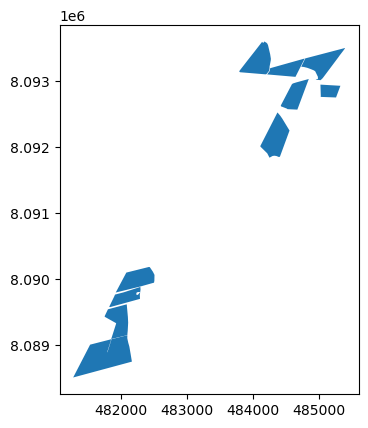

In [118]:
plan.plot()

In [120]:
# cargar el shp de planificacion existente
path_plan = r'G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\SHP\PLANIFICACION.shp'
gdf_plan = gpd.read_file(path_plan)
# union de los dos gdf
gdf_pla_gral = pd.concat([gdf_plan, plan], ignore_index=True)
# exportar los datos en nuevo shp
gdf_pla_gral.to_file(path_plan)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_31512\1968544930.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gdf_pla_gral = pd.concat([gdf_plan, plan], ignore_index=True)


# CARGAR PLANIFICACION A AMIGOCLOUD

In [121]:
def convertir_a_multipolygon(geometry):
    if isinstance(geometry, Polygon):
        return MultiPolygon([geometry])
    return geometry

def convertir_a_wkb(polygon):
    wkb_data = wkb.dumps(polygon, hex=True)
    return wkb_data

In [125]:
# repreyectar a WGS84
plan = plan.to_crs(epsg=4326)
# convertir poligonos a multipoligonos
plan['geometry'] = plan['geometry'].apply(convertir_a_multipolygon)

In [126]:
plan

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,geometry,sem_reg,fecha_ini,origen,dias,fecha,sem_plan
0,19,SANTA BARBARA,388,AGROPECUARIA MARIANA S.R.L.,L9.1,13.370000,"MULTIPOLYGON (((-63.14363 -17.24610, -63.14306...",0.0,,SOLICITUD,0,,0
1,19,SANTA BARBARA,454,AYALA ESPINOSA LEOPOLDO,L30.3,30.620000,"MULTIPOLYGON (((-63.16779 -17.28644, -63.17072...",0.0,,SOLICITUD,0,,0
2,19,SANTA BARBARA,388,AGROPECUARIA MARIANA S.R.L.,L10.2,10.320000,"MULTIPOLYGON (((-63.14419 -17.25197, -63.14558...",0.0,,SOLICITUD,0,,0
3,19,SANTA BARBARA,388,AGROPECUARIA MARIANA S.R.L.,L2,14.000000,"MULTIPOLYGON (((-63.15082 -17.24697, -63.15191...",0.0,,SOLICITUD,0,,0
4,19,SANTA BARBARA,454,AYALA ESPINOSA LEOPOLDO,L28.1,12.730000,"MULTIPOLYGON (((-63.16463 -17.27564, -63.16463...",0.0,,SOLICITUD,0,,0
5,19,SANTA BARBARA,18358,ROJAS AMELUNGE CARLOS,L30.11,11.686298,"MULTIPOLYGON (((-63.16838 -17.28224, -63.16842...",0.0,16/5/2024,SIEMBRA 2023,42,2024-05-16,1
6,19,SANTA BARBARA,18358,ROJAS AMELUNGE CARLOS,L30.1,7.108919,"MULTIPOLYGON (((-63.16891 -17.27695, -63.16659...",0.0,16/5/2024,SIEMBRA 2023,42,2024-05-16,1
7,19,SANTA BARBARA,18358,ROJAS AMELUNGE CARLOS,L11.3,4.871902,"MULTIPOLYGON (((-63.13868 -17.25031, -63.14087...",24.0,2024-05-25,SIEMBRA 2024,33,2024-05-25,1
8,19,SANTA BARBARA,18358,ROJAS AMELUNGE CARLOS,L15,16.591264,"MULTIPOLYGON (((-63.14668 -17.25841, -63.14682...",24.0,2024-04-21,SIEMBRA 2024,67,2024-04-21,1
9,19,SANTA BARBARA,18358,ROJAS AMELUNGE CARLOS,L5,8.271319,"MULTIPOLYGON (((-63.14805 -17.24630, -63.14313...",24.0,2024-05-24,SIEMBRA 2024,34,2024-05-24,1


In [128]:
# recorrer el gdf de lotes y cargarlo a amigocloud
id_proyecto = f'https://app.amigocloud.com/api/v1/projects/33457/sql'
for index, row in plan.iterrows():
    wkb_hex = convertir_a_wkb(row['geometry'])
    insert_sql = f"""
    INSERT INTO dataset_345601 (sem_reg, unidad_01, unidad_02, unidad_03, unidad_04, unidad_05, area, origen, dias, sem_plan, geometry)
    VALUES ({row['sem_reg']}, {row['unidad_01']}, '{row['unidad_02']}', {row['unidad_03']}, '{row['unidad_04']}', '{row['unidad_05']}', {row['area']}, '{row['origen']}', '{row['dias']}', '{row['sem_plan']}', ST_SetSRID(ST_GeomFromWKB('\\x{wkb_hex}'), 4326));
    """
    query_sql = {'query': insert_sql}
    resultado_post = amigocloud.post(id_proyecto, query_sql)

# CREAR XLSX

In [120]:
path_plan_XLSX = f"G:/Ingenio Azucarero Guabira S.A/UTEA - SEMANAL - EQUIPO AVIACION UTEA/Trichogramma/2024/XLSX_PLAN/S{semana}.xlsx"
path_plan_XLSX

'G:/Ingenio Azucarero Guabira S.A/UTEA - SEMANAL - EQUIPO AVIACION UTEA/Trichogramma/2024/XLSX_PLAN/S23.xlsx'

In [123]:
poligonos_intersect.columns

Index(['sem_reg', 'unidad_01', 'unidad_02', 'unidad_03', 'unidad_04',
       'unidad_05', 'area', 'fecha_ini', 'origen', 'dias', 'geometry',
       'sem_plan'],
      dtype='object')

In [128]:
df_xlsx = poligonos_intersect[['sem_reg', 'unidad_01', 'unidad_02', 'unidad_03', 'unidad_04', 'unidad_05', 'area', 'fecha_ini', 'origen', 'dias', 'sem_plan']]

In [129]:
df_xlsx.to_excel(path_plan_XLSX, index=False, engine='openpyxl')